# `COUP0000_PI_SOM` on Derecho

# Setup

In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import pickle as pkl

import xcdat as xc
import xskillscore as xs

import cartopy
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.path as mpath

import matplotlib.gridspec as gs

import cmocean.cm as cmo

In [2]:
## Some magic to automatically reload my functions before running a new cell
%load_ext autoreload
%autoreload 1
%aimport climate_data_science_functions

import climate_data_science_functions as cds

## Figure settings

In [3]:
## Adjust dpi
mpl.rcParams['figure.dpi'] = 100

## Assign figure output format
# %config InlineBackend.figure_formats = ['pdf']  ## vector, transparent background -> best for publication
%config InlineBackend.figure_formats = ['png']  ## raster, transparent background -> best for publication of large, dense figures
# %config InlineBackend.figure_formats = ['jpg']  ## raster, white background -> best for adding to notes

## Optional Dask cluster

In [6]:
# Updated for PBS scheduler this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    """Code from Daniel Kennedy"""
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='UWAS0098', # Input your project ID here
        walltime='1:00:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    client = Client(cluster)
    return cluster, client

# This makes things go fast, but uses up computing time (charged for Casper usage)
# If you don't do this, making dset_dict will take a long time
# cluster, client = get_ClusterClient()
# cluster.scale(2) #20

# Dictionaries and constants
## `COUP0000_PI_SOM`

In [4]:
case = 'COUP0000_PI_SOM'

path = {
    'd':'/glade/derecho/scratch/bbuchovecky/archive/COUP0000_PI_SOM/',
    'c':'/glade/cheyenne/scratch/bbuchovecky/archive/COUP0000_PI_SOM/'
}

scomp = {
    'atm': 'cam',
    'lnd': 'clm2'
}

variable = {
    'atm':{
        'TREFHT':'near-surface air temperature [K]',
        'PS':'surface pressure [Pa]'
    },
    'lnd':{
        'NPP':'net primary production [gC/m2/s]',
        'EFLX_LH_TOT':'total latent heat flux [W/m2]',
        'FSH_TO_COUPLER':'sensible heat flux [W/m2]',
        'TLAI':'total projected leaf area index [m2/m2]'
    }
}

tslice = slice('0049-01','0069-12')

## CESM2-LE

In [8]:
le_path = "/glade/campaign/cgd/cesm/CESM2-LE/timeseries/"

le_path = {
    'atm':'/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/month_1/',
    'lnd':'/glade/campaign/cgd/cesm/CESM2-LE/timeseries/lnd/proc/tseries/month_1/'
}

color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
         'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

is_yr = ['1001', '1021', '1041', '1061', '1081', '1101', '1121', '1141', '1161', '1181']

# Get output
## `COUP0000_PI_SOM`

In [5]:
# Get latitude coordinate
fname = case+'.'+scomp['atm']+'.h0.timeseries.TREFHT.nc'
atmlat = xr.open_dataset(path['c']+'atm'+'/proc/tseries/'+fname).lat

fname = case+'.'+scomp['lnd']+'.h0.timeseries.NPP.nc'
lndlat = xr.open_dataset(path['c']+'lnd'+'/proc/tseries/'+fname).lat

dd = {}
for cc in path.keys():
    dd[cc] = {}
    for gc in variable.keys():
        dd[cc][gc] = {}
        for vv in variable[gc].keys():
            fname = case+'.'+scomp[gc]+'.h0.timeseries.'+vv.upper()+'.nc'
            dd[cc][gc][vv] = xr.open_dataset(path[cc]+gc+'/proc/tseries/'+fname)[vv.upper()]
            dd[cc][gc][vv] = dd[cc][gc][vv].sel(time=tslice)

            if gc == 'atm':
                dd[cc][gc][vv]['lat'] = atmlat
            if gc == 'lnd':
                dd[cc][gc][vv]['lat'] = lndlat

## CESM2-LE

In [ ]:
le_dd = {}

for gc in le_path.keys():
# for gc in ['atm']:
    le_dd[gc] = {}
    for vv in variable[gc].keys():    
    # for vv in ['TREFHT']:
        ens = []
        for yr in is_yr:
            # print(le_path[gc]+vv.upper()+'/b.e21.*cmip6.f09_g17.LE2-'+yr+'.*.*.h0.'+vv.upper()+'.*.nc')
            da = xr.open_mfdataset(le_path[gc]+vv.upper()+'/b.e21.*cmip6.f09_g17.LE2-'+yr+'.*.*.h0.'+vv.upper()+'.*.nc')
            ens.append(da)
        le_dd[gc][vv] = xr.combine_nested(ens, concat_dim='member', combine_attrs='override')[vv]
        le_dd[gc][vv] = le_dd[gc][vv].assign_coords(start_yr=is_yr)

/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/month_1/TREFHT/b.e21.*cmip6.f09_g17.LE2-1001.*.*.h0.TREFHT.*.nc
/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/month_1/TREFHT/b.e21.*cmip6.f09_g17.LE2-1021.*.*.h0.TREFHT.*.nc
/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/month_1/TREFHT/b.e21.*cmip6.f09_g17.LE2-1041.*.*.h0.TREFHT.*.nc
/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/month_1/TREFHT/b.e21.*cmip6.f09_g17.LE2-1061.*.*.h0.TREFHT.*.nc
/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/month_1/TREFHT/b.e21.*cmip6.f09_g17.LE2-1081.*.*.h0.TREFHT.*.nc
/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/month_1/TREFHT/b.e21.*cmip6.f09_g17.LE2-1101.*.*.h0.TREFHT.*.nc
/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/month_1/TREFHT/b.e21.*cmip6.f09_g17.LE2-1121.*.*.h0.TREFHT.*.nc
/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/month_1/TREFHT/b.e21.*cmip6.f09_g17.LE2-1141.*.*.h0.TREF

# Functions

In [6]:
def plot_distance(var, gen_comp, metric, time=None, **kwargs):
    if metric == 'error':
        if type(time) == int:
            error = dd['d'][gen_comp][var].isel(time=time) - dd['c'][gen_comp][var].isel(time=time)
        if type(time) == str:
            error = dd['d'][gen_comp][var].sel(time=time) - dd['c'][gen_comp][var].sel(time=time)
        error.plot(cmap=cmo.balance, extend='both',
                   cbar_kwargs={'label':var.upper()+' ['+variable[gen_comp][var].split('[')[1]},
                   **kwargs)
        plt.title('Error at time='+str(time))

    if metric == 'perror':
        if type(time) == int:
            diff = dd['d'][gen_comp][var].isel(time=time) - dd['c'][gen_comp][var].isel(time=time)
            error = diff / dd['c'][gen_comp][var].isel(time=time)
            error = abs(error)
        if type(time) == str:
            diff = dd['d'][gen_comp][var].sel(time=time) - dd['c'][gen_comp][var].sel(time=time)
            error = diff / dd['c'][gen_comp][var].sel(time=time)
            error = abs(error)
        error.plot(cmap=cmo.thermal, extend='both',
                   cbar_kwargs={'label':var.upper()+' ['+variable[gen_comp][var].split('[')[1]},
                   **kwargs)
        plt.title('Percent error at time='+str(time))

    if metric == 'mae':
        mae = xs.mae(dd['d'][gen_comp][var], dd['c'][gen_comp][var], dim='time')
        mae.plot(vmin=0, cmap=cmo.thermal, extend='max',
                 cbar_kwargs={'label':var.upper()+' ['+variable[gen_comp][var].split('[')[1]},
                 **kwargs)
        plt.title('MAE over time dimension')
        
    if metric == 'rmse':
        rmse = xs.rmse(dd['d'][gen_comp][var], dd['c'][gen_comp][var], dim='time')
        rmse.plot(vmin=0, cmap=cmo.thermal, extend='max',
                  cbar_kwargs={'label':var.upper()+' ['+variable[gen_comp][var].split('[')[1]},
                  **kwargs)
        plt.title('RMSE over time dimension')

    if metric == 'mape':
        mape = xs.mape(dd['d'][gen_comp][var], dd['c'][gen_comp][var], dim='time')
        mape.plot(vmin=0, cmap=cmo.thermal, extend='max',
                  cbar_kwargs={'label':var.upper()+' ['+variable[gen_comp][var].split('[')[1]},
                  **kwargs)
        plt.title('MAPE over time dimension')

    if metric == 'smape':
        smape = xs.smape(dd['d'][gen_comp][var], dd['c'][gen_comp][var], dim='time')
        smape.plot(vmin=0, cmap=cmo.thermal, extend='max',
                  cbar_kwargs={'label':var.upper()+' ['+variable[gen_comp][var].split('[')[1]},
                  **kwargs)
        plt.title('SMAPE over time dimension')

# Distance metrics

## Surface pressure

Text(0.5, 0.98, 'Zonal-mean Absolute Error')

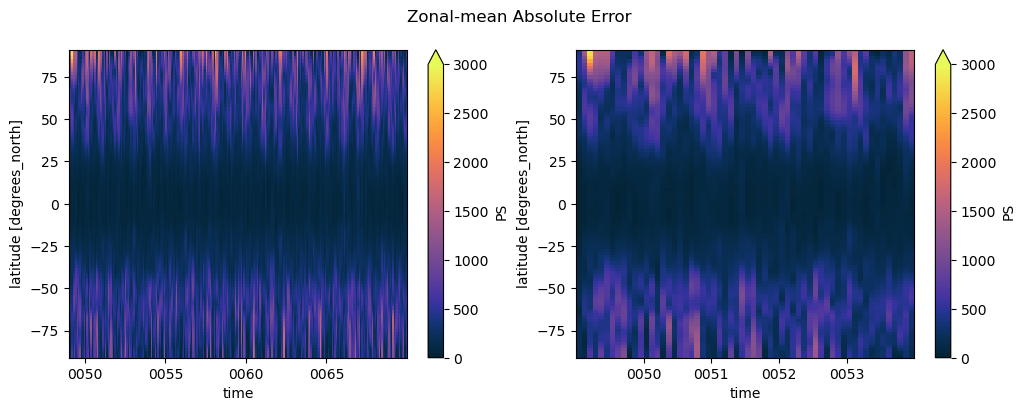

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax = axes.ravel()

full_ts = abs(dd["d"]["atm"]["ps"] - dd["c"]["atm"]["ps"])
full_ts = full_ts.mean(dim="lon")
full_ts = full_ts.T
full_ts.plot(ax=ax[0], cmap=cmo.thermal, vmin=0, vmax=3000, extend="max")

short_ts = abs(dd["d"]["atm"]["ps"] - dd["c"]["atm"]["ps"])
short_ts = short_ts.isel(time=slice(0, 60))
short_ts = short_ts.mean(dim="lon")
short_ts = short_ts.T
short_ts.plot(ax=ax[1], cmap=cmo.thermal, vmin=0, vmax=3000, extend="max")

plt.suptitle("Zonal-mean Absolute Error")

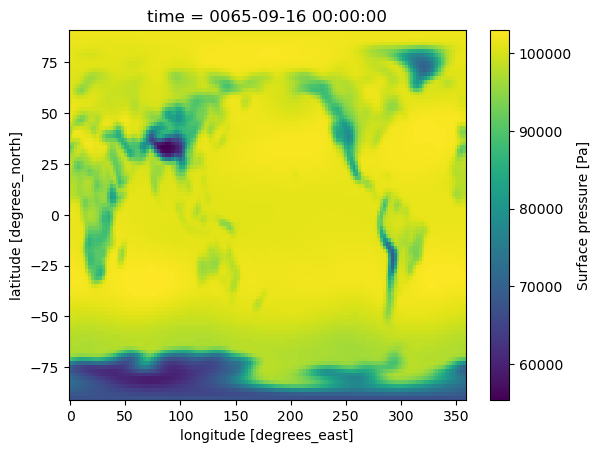

In [8]:
(dd['d']['atm']['ps'].isel(time=200)).plot()

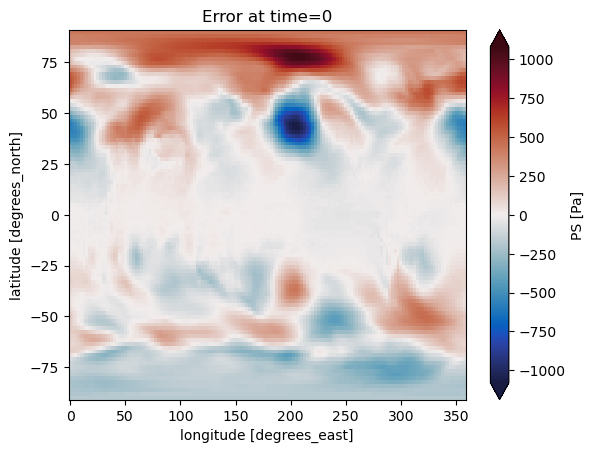

In [9]:
plot_distance('ps', 'atm', 'error', time=0)

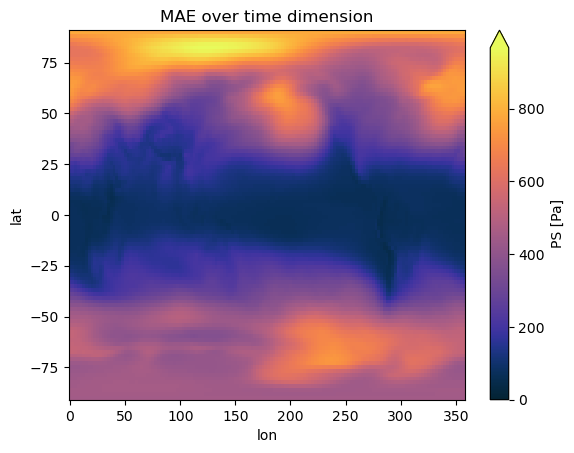

In [15]:
plot_distance('ps', 'atm', 'mae')

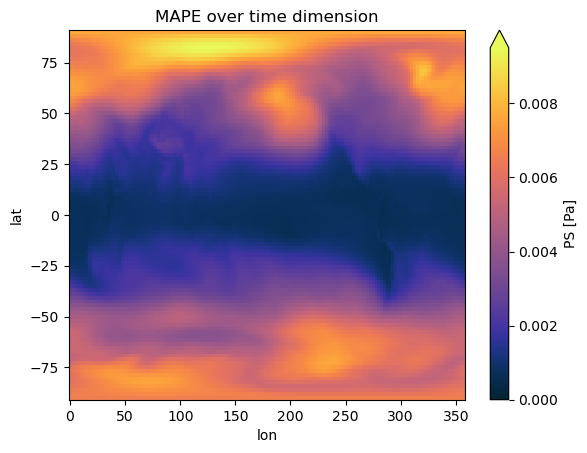

In [132]:
plot_distance('ps', 'atm', 'mape')

## Near-surface air temperature

### Global-mean 20-year average

In [8]:
d_trefht = xc.open_dataset('/glade/derecho/scratch/bbuchovecky/archive/COUP0000_PI_SOM/atm/proc/tseries/COUP0000_PI_SOM.cam.h0.timeseries.TREFHT.nc', data_var='TREFHT').sel(time=tslice)
c_trefht = xc.open_dataset('/glade/cheyenne/scratch/bbuchovecky/archive/COUP0000_PI_SOM/atm/proc/tseries/COUP0000_PI_SOM.cam.h0.timeseries.TREFHT.nc', data_var='TREFHT').sel(time=tslice)

# d_trefht = xr.open_dataset('/glade/derecho/scratch/bbuchovecky/archive/COUP0000_PI_SOM/atm/proc/tseries/COUP0000_PI_SOM.cam.h0.timeseries.TREFHT.nc').sel(time=tslice)
# c_trefht = xr.open_dataset('/glade/cheyenne/scratch/bbuchovecky/archive/COUP0000_PI_SOM/atm/proc/tseries/COUP0000_PI_SOM.cam.h0.timeseries.TREFHT.nc').sel(time=tslice)

for ds in [d_trefht, c_trefht]:
    ds.lat.attrs['axis'] = 'Y'
    ds.lon.attrs['axis'] = 'X'

In [9]:
d_trefht_globmean = d_trefht.spatial.average('TREFHT', axis=['X', 'Y'])['TREFHT']
c_trefht_globmean = c_trefht.spatial.average('TREFHT', axis=['X', 'Y'])['TREFHT']

diff_trefht_globmean = d_trefht_globmean - c_trefht_globmean
diff_trefht_globmean.mean()

<xarray.DataArray 'TREFHT' ()>
array(0.12811203)

In [10]:
d_trefht_globmean = cds.coslat_area_avg(dd['d']['atm']['TREFHT'])
c_trefht_globmean = cds.coslat_area_avg(dd['c']['atm']['TREFHT'])
diff_trefht_globmean = d_trefht_globmean - c_trefht_globmean
diff_trefht_globmean.mean()

<xarray.DataArray ()>
array(0.08068257)

In [12]:
lat = d_trefht.lat
weights = np.cos(np.deg2rad(lat))
weights = weights.fillna(0)
weights.name = 'weights'

d_trefht_weighted = d_trefht.weighted(weights)
c_trefht_weighted = c_trefht.weighted(weights)

# d_trefht_weighted_mean = d_trefht_weighted.mean(('lon','lat'))
# c_trefht_weighted_mean = c_trefht_weighted.mean(('lon','lat'))


In [13]:
weights

<xarray.DataArray 'weights' (lat: 96)>
array([6.12323400e-17, 3.30633693e-02, 6.60905843e-02, 9.90455303e-02,
       1.31892171e-01, 1.64594590e-01, 1.97117027e-01, 2.29423920e-01,
       2.61479941e-01, 2.93250037e-01, 3.24699469e-01, 3.55793847e-01,
       3.86499169e-01, 4.16781860e-01, 4.46608807e-01, 4.75947393e-01,
       5.04765538e-01, 5.33031729e-01, 5.60715057e-01, 5.87785252e-01,
       6.14212713e-01, 6.39968541e-01, 6.65024572e-01, 6.89353409e-01,
       7.12928448e-01, 7.35723911e-01, 7.57714870e-01, 7.78877279e-01,
       7.99187997e-01, 8.18624815e-01, 8.37166478e-01, 8.54792713e-01,
       8.71484244e-01, 8.87222819e-01, 9.01991230e-01, 9.15773327e-01,
       9.28554038e-01, 9.40319390e-01, 9.51056516e-01, 9.60753676e-01,
       9.69400266e-01, 9.76986831e-01, 9.83505075e-01, 9.88947871e-01,
       9.93309266e-01, 9.96584493e-01, 9.98769969e-01, 9.99863305e-01,
       9.99863305e-01, 9.98769969e-01, 9.96584493e-01, 9.93309266e-01,
       9.88947871e-01, 9.83505075e-01, 9.76986831e-01, 9.69400266e-01,
       9.60753676e-01, 9.51056516e-01, 9.40319390e-01, 9.28554038e-01,
       9.15773327e-01, 9.01991230e-01, 8.87222819e-01, 8.71484244e-01,
       8.54792713e-01, 8.37166478e-01, 8.18624815e-01, 7.99187997e-01,
       7.78877279e-01, 7.57714870e-01, 7.35723911e-01, 7.12928448e-01,
       6.89353409e-01, 6.65024572e-01, 6.39968541e-01, 6.14212713e-01,
       5.87785252e-01, 5.60715057e-01, 5.33031729e-01, 5.04765538e-01,
       4.75947393e-01, 4.46608807e-01, 4.16781860e-01, 3.86499169e-01,
       3.55793847e-01, 3.24699469e-01, 2.93250037e-01, 2.61479941e-01,
       2.29423920e-01, 1.97117027e-01, 1.64594590e-01, 1.31892171e-01,
       9.90455303e-02, 6.60905843e-02, 3.30633693e-02, 2.83276945e-16])
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y
    bounds:         lat_bnds

In [14]:
d_trefht.spatial.get_weights(axis=['X', 'Y']).isel(lon=0)

<xarray.DataArray 'lat_lon_wts' (lat: 96)>
array([0.00034174, 0.00273334, 0.00546369, 0.00818807, 0.01090349,
       0.01360699, 0.01629561, 0.01896641, 0.02161647, 0.0242429 ,
       0.02684282, 0.02941338, 0.03195178, 0.03445524, 0.03692103,
       0.03934644, 0.04172883, 0.04406559, 0.04635416, 0.04859204,
       0.0507768 , 0.05290602, 0.0549774 , 0.05698866, 0.0589376 ,
       0.06082209, 0.06264008, 0.06438957, 0.06606865, 0.06767549,
       0.06920832, 0.07066548, 0.07204536, 0.07334647, 0.07456737,
       0.07570673, 0.07676331, 0.07773594, 0.07862358, 0.07942524,
       0.08014005, 0.08076723, 0.08130609, 0.08175605, 0.0821166 ,
       0.08238736, 0.08256804, 0.08265842, 0.08265842, 0.08256804,
       0.08238736, 0.0821166 , 0.08175605, 0.08130609, 0.08076723,
       0.08014005, 0.07942524, 0.07862358, 0.07773594, 0.07676331,
       0.07570673, 0.07456737, 0.07334647, 0.07204536, 0.07066548,
       0.06920832, 0.06767549, 0.06606865, 0.06438957, 0.06264008,
       0.06082209, 0.0589376 , 0.05698866, 0.0549774 , 0.05290602,
       0.0507768 , 0.04859204, 0.04635416, 0.04406559, 0.04172883,
       0.03934644, 0.03692103, 0.03445524, 0.03195178, 0.02941338,
       0.02684282, 0.0242429 , 0.02161647, 0.01896641, 0.01629561,
       0.01360699, 0.01090349, 0.00818807, 0.00546369, 0.00273334,
       0.00034174])
Coordinates:
    lon      float64 0.0
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0

In [15]:
weights / (weights + d_trefht.spatial.get_weights(axis=['X', 'Y']).isel(lon=0))

<xarray.DataArray (lat: 96)>
array([1.79179448e-13, 9.23642712e-01, 9.23642712e-01, 9.23642712e-01,
       9.23642712e-01, 9.23642712e-01, 9.23642712e-01, 9.23642712e-01,
       9.23642712e-01, 9.23642712e-01, 9.23642712e-01, 9.23642712e-01,
       9.23642712e-01, 9.23642712e-01, 9.23642712e-01, 9.23642712e-01,
       9.23642712e-01, 9.23642712e-01, 9.23642712e-01, 9.23642712e-01,
       9.23642712e-01, 9.23642712e-01, 9.23642712e-01, 9.23642712e-01,
       9.23642712e-01, 9.23642712e-01, 9.23642712e-01, 9.23642712e-01,
       9.23642712e-01, 9.23642712e-01, 9.23642712e-01, 9.23642712e-01,
       9.23642712e-01, 9.23642712e-01, 9.23642712e-01, 9.23642712e-01,
       9.23642712e-01, 9.23642712e-01, 9.23642712e-01, 9.23642712e-01,
       9.23642712e-01, 9.23642712e-01, 9.23642712e-01, 9.23642712e-01,
       9.23642712e-01, 9.23642712e-01, 9.23642712e-01, 9.23642712e-01,
       9.23642712e-01, 9.23642712e-01, 9.23642712e-01, 9.23642712e-01,
       9.23642712e-01, 9.23642712e-01, 9.23642712e-01, 9.23642712e-01,
       9.23642712e-01, 9.23642712e-01, 9.23642712e-01, 9.23642712e-01,
       9.23642712e-01, 9.23642712e-01, 9.23642712e-01, 9.23642712e-01,
       9.23642712e-01, 9.23642712e-01, 9.23642712e-01, 9.23642712e-01,
       9.23642712e-01, 9.23642712e-01, 9.23642712e-01, 9.23642712e-01,
       9.23642712e-01, 9.23642712e-01, 9.23642712e-01, 9.23642712e-01,
       9.23642712e-01, 9.23642712e-01, 9.23642712e-01, 9.23642712e-01,
       9.23642712e-01, 9.23642712e-01, 9.23642712e-01, 9.23642712e-01,
       9.23642712e-01, 9.23642712e-01, 9.23642712e-01, 9.23642712e-01,
       9.23642712e-01, 9.23642712e-01, 9.23642712e-01, 9.23642712e-01,
       9.23642712e-01, 9.23642712e-01, 9.23642712e-01, 8.28931356e-13])
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
    lon      float64 0.0

### Zonal-mean time series

Text(0.5, 0.98, 'Zonal-mean Absolute Error')

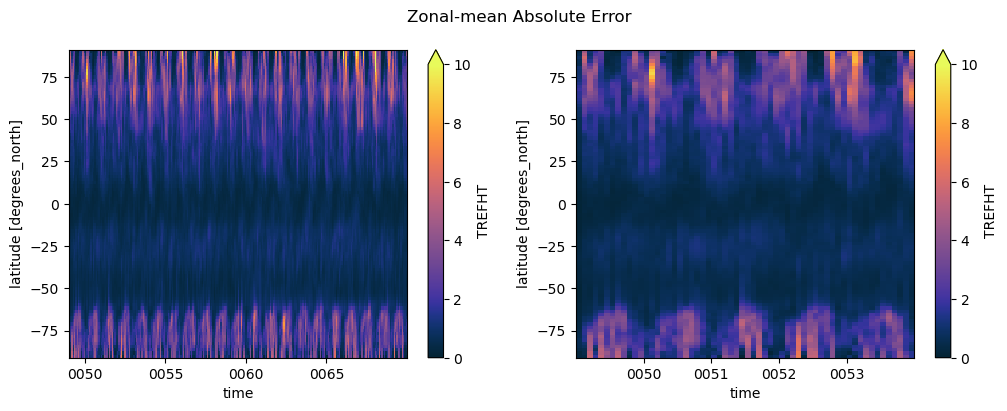

In [40]:
fig,axes = plt.subplots(1,2,figsize=(12,4))
ax = axes.ravel()

abs((dd['d']['atm']['trefht'] - dd['c']['atm']['trefht'])).mean(dim='lon').T.plot(ax=ax[0], cmap=cmo.thermal, vmin=0, vmax=10, extend='max')
abs((dd['d']['atm']['trefht'] - dd['c']['atm']['trefht'])).isel(time=slice(0,60)).mean(dim='lon').T.plot(ax=ax[1], cmap=cmo.thermal, vmin=0, vmax=10, extend='max')

plt.suptitle('Zonal-mean Absolute Error')


### Maps

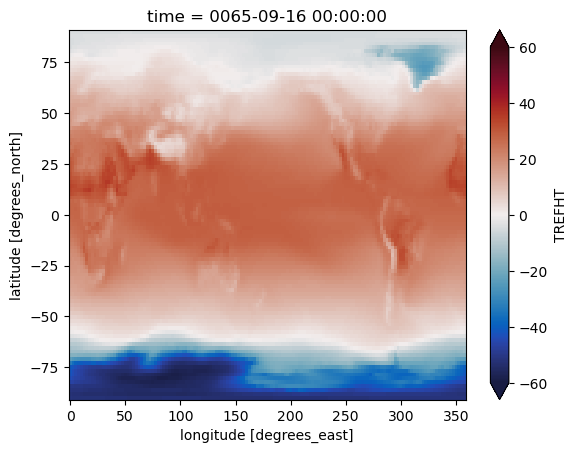

In [76]:
(dd['d']['atm']['TREFHT'].isel(time=200)-273.15).plot(cmap=cmo.balance, vmin=-60, vmax=60, extend='both')

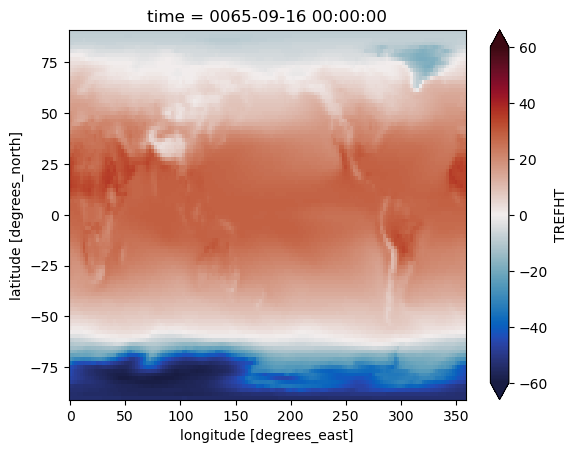

In [77]:
(dd['c']['atm']['TREFHT'].isel(time=200)-273.15).plot(cmap=cmo.balance, vmin=-60, vmax=60, extend='both')

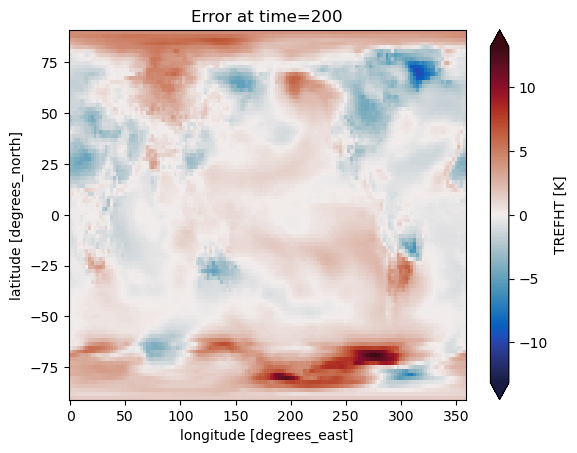

In [79]:
plot_distance('TREFHT', 'atm', 'error', time=200)

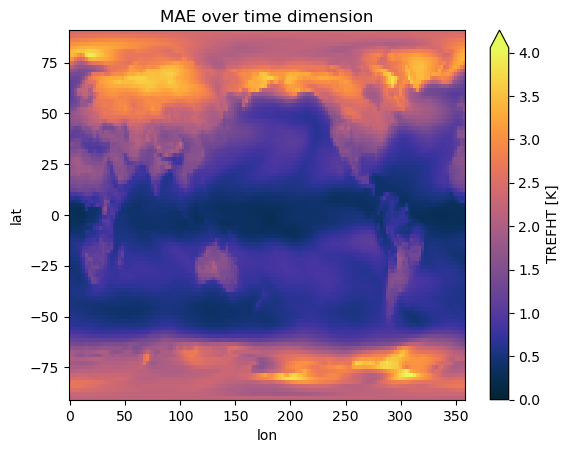

In [148]:
plot_distance('trefht', 'atm', 'mae')

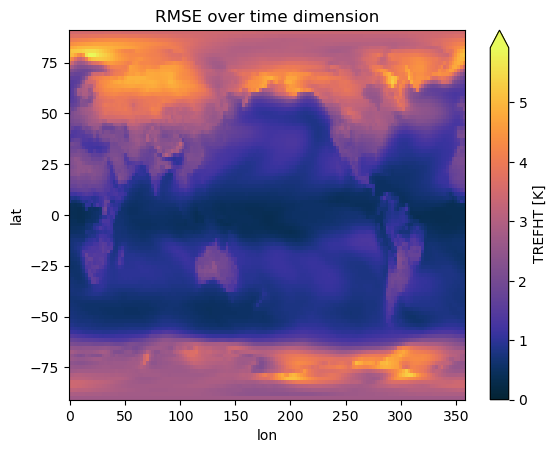

In [134]:
plot_distance('trefht', 'atm', 'rmse')


## Latent heat flux

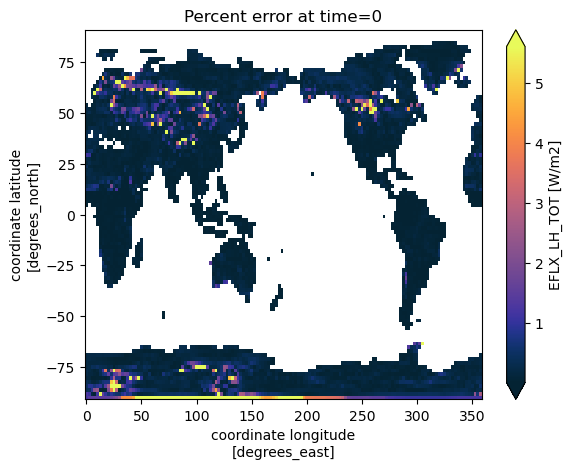

In [140]:
plot_distance('EFLX_LH_TOT', 'lnd', 'perror', time=0, robust=True)

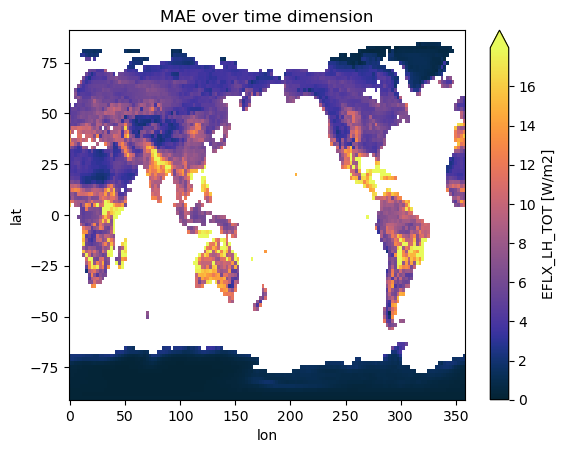

In [147]:
plot_distance('EFLX_LH_TOT', 'lnd', 'mae', robust=True)

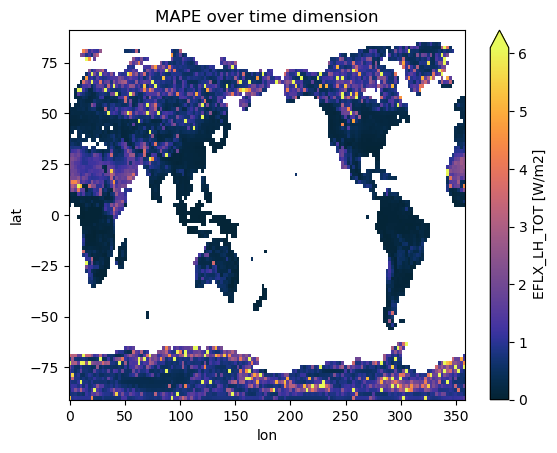

In [142]:
plot_distance('EFLX_LH_TOT', 'lnd', 'mape', robust=True)


## Sensible heat flux

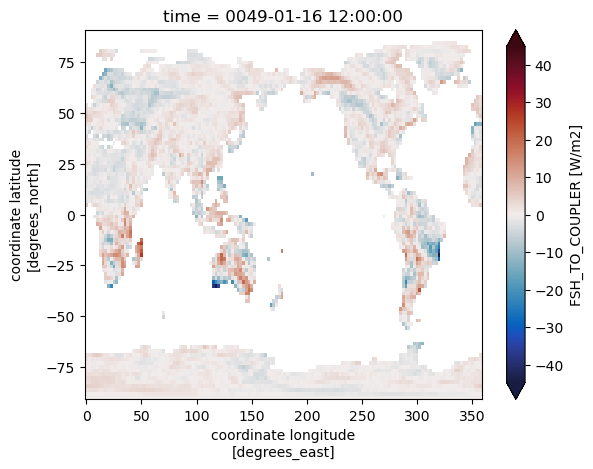

In [98]:
plot_distance('FSH_TO_COUPLER', 'lnd', 'error', time=0)

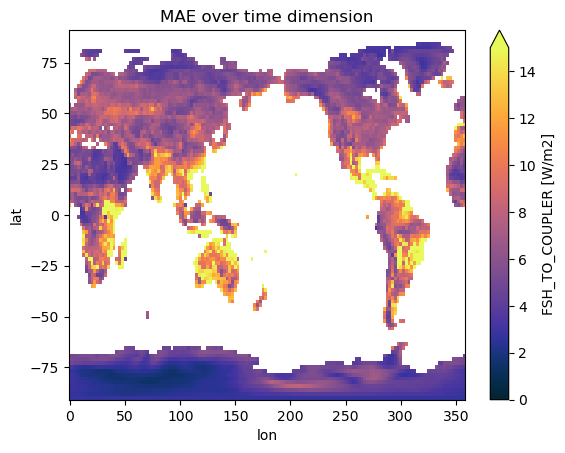

In [150]:
plot_distance('FSH_TO_COUPLER', 'lnd', 'mae', vmax=15)

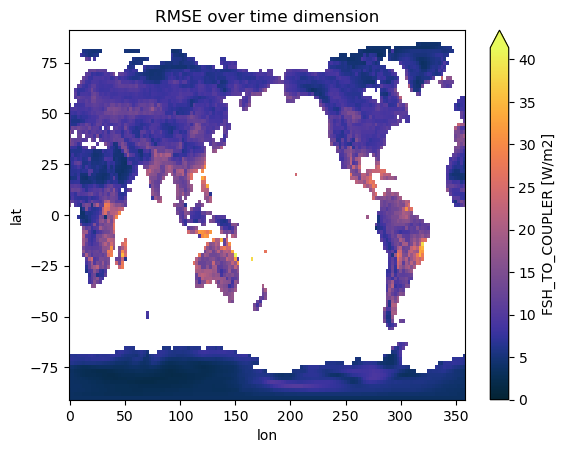

In [100]:
plot_distance('FSH_TO_COUPLER', 'lnd', 'rmse')


## LAI

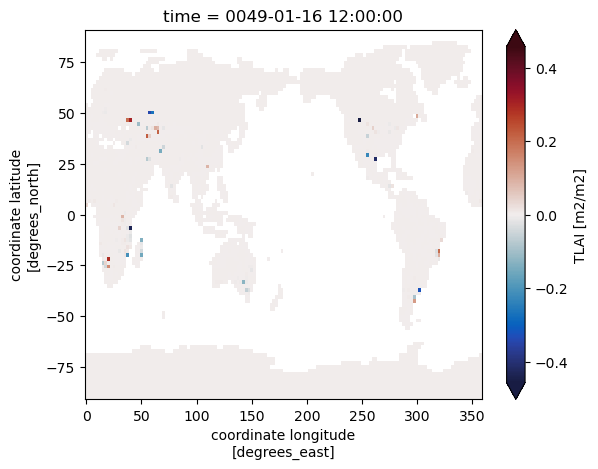

In [101]:
plot_distance('TLAI', 'lnd', 'error', time=0)

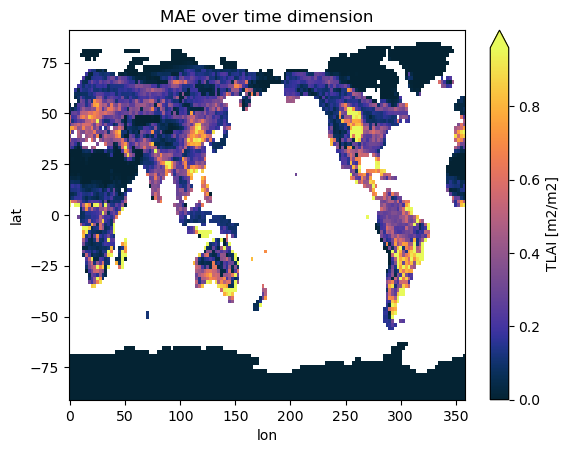

In [145]:
plot_distance('TLAI', 'lnd', 'mae', robust=True)

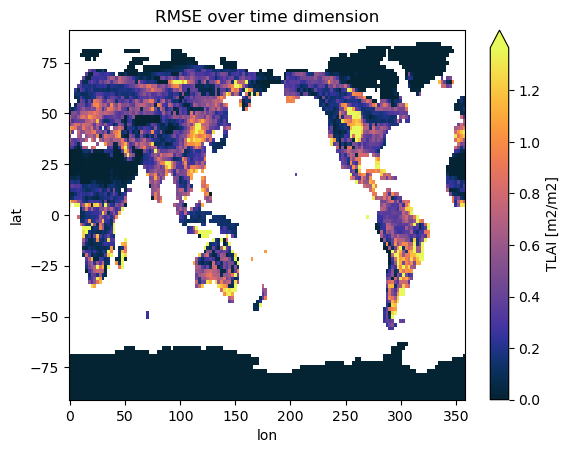

In [146]:
plot_distance('TLAI', 'lnd', 'rmse', robust=True)


# CESM2-LE

In [ ]:
le_trefht_roll = cds.coslat_area_avg(le_dd['atm']['TREFHT']).rolling(time=12*20, center=True)
le_ps_roll = cds.coslat_area_avg(le_dd['atm']['PS']).rolling(time=12*20, center=True)

le_trefht_rollstd = le_trefht_roll.std()
le_ps_rollstd = le_ps_roll.std()

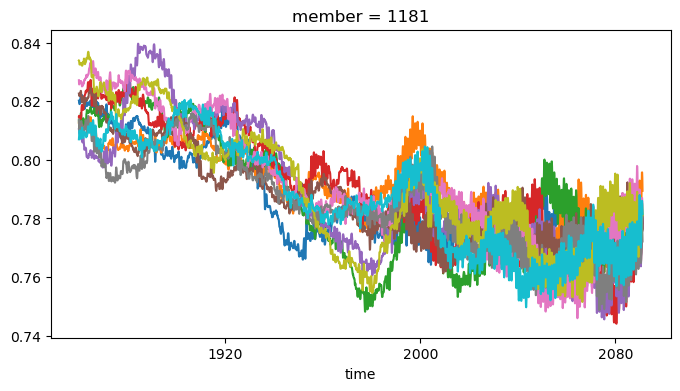

In [ ]:
fig,ax = plt.subplots(figsize=(8,4))

for i,yr in enumerate(is_yr):
    le_trefht_rollstd.sel(start_yr=yr).plot(ax=ax, color=color[i])